# Assignment 4

## Instructions
<ul>
    <li> Ensure that this assignment is your own work. PLagiarism will not be tolerated </li>
    <li> Ensure that all cells of this notebook run without error when run in order </li>
    <li> Follow the late day policy. Submit assignments on time </li>
    <li> Provide clear explanation for the algorithms you implement </li>
</ul>
Date released: 26/10/2020 

Due date: 01/11/2020 

Approximate time needed: 6-7 hours
    
## DLT and Epipolar Lines

The goal of this assignment is to aid your understanding of the Direct Linear Transform as well as Epipolar geometry.

For the first part of the assignment you will find correspondences between 2D-3D points and estimate the P Matrix. You will then be required to estimate Camera Parameters from this P matrix.

The second part of this assignment will require you to construct epipolar lines on two corresponding images.

---
## 4.1
### Generating Correspondences
The first step to perform DLT is to generate correspondences. The cell below opens a new window. Clicking anywhere on the image should give you the pixel location of the image. Once you're done clicking, close the image window. The cell after displays the points you have clicked.

In [3]:
%matplotlib tk
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np


image_points = []
fig = plt.figure(figsize=(20,30))

img=mpimg.imread('Images/dlt1.jpeg')

def onclick(event):
    ix, iy = event.xdata, event.ydata
    # print(ix, iy)
    image_points.append([ix, iy])

cid = fig.canvas.mpl_connect('button_press_event', onclick)

imgplot = plt.imshow(img)
plt.show()

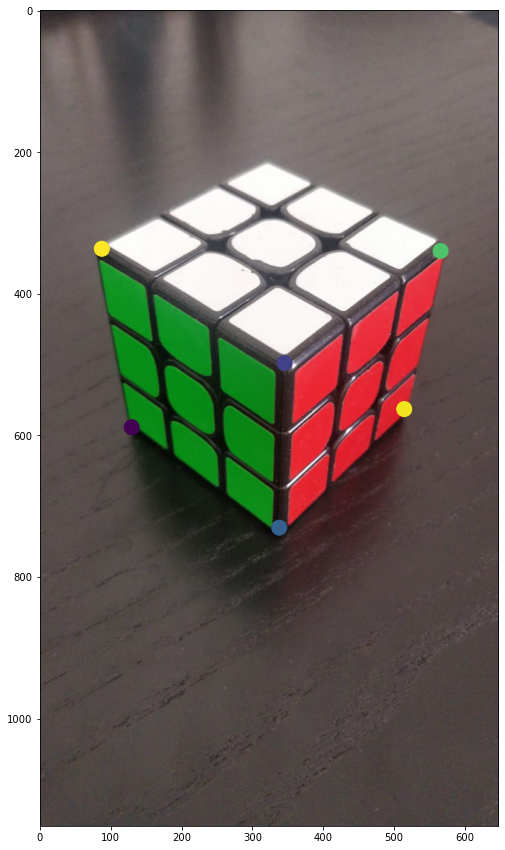

In [4]:
%matplotlib inline
N = len(image_points)
image_points = np.array(image_points)
fig = plt.figure(figsize=(10,15))

img=mpimg.imread('Images/dlt1.jpeg')
imgplot = plt.imshow(img)

colors = np.random.rand(N)
area = (15 * np.ones(N))**2 

plt.scatter(image_points[:,0], image_points[:,1], c=colors, s=area)
plt.show()

After generating pixel locations, you have to generate the corresponding world points. You have the freedom to chose which point you want as origin. You can consider each side as 4 units.

Ensure that the ordering of your points matches the ordering of image points. Keep track of the sequence of corners clicked.

### Origin Chosen : Bottom point b/w Red and Green

In [5]:
#We'll rename image_points to x to match textbook convention
x = image_points
# X represents the 3D world points
X = []
#Add your points here
#Add them as 3D points only
# X.append([1,0,0])
X.append([0,4,0])
X.append([0,0,0])
X.append([4,0,0])
X.append([0,4,4])
X.append([0,0,4])
X.append([4,0,4])

X = np.array(X)

Now that we have the correspondences, we can estimate the P matrix. Implement the DLT function that returns the P matrix

Quick recap: x_i = P * X_i where (x_i, X_i) is the ith correspondence, and P is a 3x4 dimensional matrix. P is further decomposed as P = K * [ R | T].


In [6]:
#Helper functions
#appends a ones column to input
def hom_coords(x,X):
    n = x.shape[0]
    size = (n,1)
    ones = np.ones(size)
    x = np.concatenate(
        (x,ones),
        axis = 1)
    X = np.concatenate(
        (X,ones),
        axis = 1)
    return x, X

x,X = hom_coords(x,X)

#### Explanation

Edit this cell and explain the DLT algorithm:

Since we don't have given camera intrinsic(5) and extrinsic(6) parameters, that means  there are total 11 unknowns, which means we need total 11 equations minimum to solve for camera parametrs.
x = P.X
we need to find 'P'  'X' are 3D points and x is 2D projected point. we construct a_xTranspose_i & a_yTranspose_i matrices for each i correspondences.
We collect all of them in a tall matrix called 'M'. then we do Singular Value Decomposition of M id est M = U*S*VT
if we take last column of V matrix we get P in row major format.
The P matrix contains info of all camera parameters.
P = K * [R | T]  where R&K are  3x3 matrices and T is 3x1

In [7]:
#DLT function takes as input 
#the image points and world points
#return a 3x4 matrix
def DLT(x,X):
    """
    your code here
    """
    M = []
    for j in range(X.shape[0]):
        #aT_xi expression
        aT_xi = []
        aT_xi = np.concatenate((aT_xi,-X[j,:],np.zeros(4), x[j,0]*X[j,:]),axis = 0)

        #aT_yi expression
        aT_yi = []
        aT_yi = np.concatenate((aT_yi,np.zeros(4),-X[j,:],x[j,1]*X[j,:]),axis = 0)
        
        M.append(aT_xi)
        M.append(aT_yi)
#     print(M)   
    
    U, S, V = np.linalg.svd(M)
    
    p_r = V[V.shape[0]-1,:]
    
    P = np.reshape(p_r,(3,4))
    
    #take last column of V , that is teh answer

#     P = np.random.randn(3,4)
    return P

P = DLT(x,X)
# print(P.shape)



## Analysing P

The next part of this question is to analyse how good our estimate is. Report the reprojection error of your P matrix

In [8]:
#Get reprojected points
def get_points(P,X):
    points = P@X.T
    points = points / points[2]
    points = points.T[:,0:2]
    return points

#Get reprojection error
def get_err(x, X, P):
    points = get_points(P, X)
    """
    find the MSE between reprojected points
    and x
    """
    x_e = x[:,0:2]
    points_e = points[:,0:2]
    
    x_e = np.reshape(x_e,(x_e.shape[0]*2))
    points_e = np.reshape(points_e,(points_e.shape[0]*2))
    
    err = x_e - points_e
    err = np.square(err)
    err = np.sum(err)/(points_e.shape[0])
    
    #to err is to human
    return err

print("Error = ",get_err(x,X,P))




Error =  0.7898973292158998


Given the P matrix, we can estimate K, R and T. Write a function that returns K,R,T given P.
Note: 
P = K * [R | T] where K is a 3x3 matrix and [R | T], P are 3x4 matrices

In [11]:
def ret_RKT(P):
    """
    """
    H_inf = P[:,0:3]
    h = P[:,3]
    
    T = np.linalg.inv(H_inf)@h
    q, r = np.linalg.qr(np.linalg.inv(H_inf)) 
    R = np.linalg.inv(q)
    K = np.linalg.inv(r)
    return R, K , T

R,K,T = ret_RKT(P)
print("R : ", R )
print()
print(" K: ", K)
print()
print(" T: ", T)

R :  [[-0.48510493  0.8560063  -0.17867966]
 [-0.58950028 -0.47104767 -0.65620387]
 [-0.64588128 -0.21299602  0.7331235 ]]

 K:  [[-9.00380704e-02 -8.75720483e-03 -5.73330212e-02]
 [ 0.00000000e+00  9.45440099e-02 -5.89325741e-02]
 [-0.00000000e+00 -0.00000000e+00 -9.27948321e-05]]

 T:  [  6.018717     5.42466648 -11.18570027]


Reproject the world points with P matrix you have obtained via DLT:

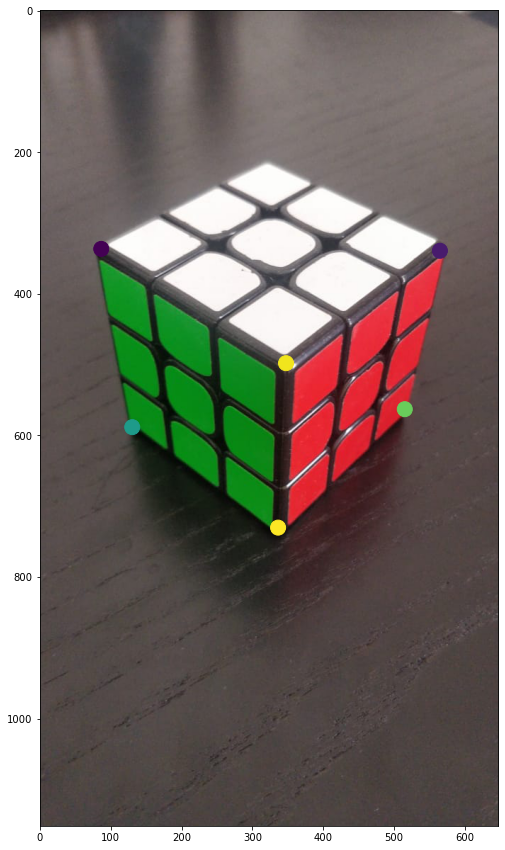

In [12]:
re_proj = get_points(P, X)
#code to plot these on the image
%matplotlib inline
N = len(re_proj)
fig = plt.figure(figsize=(10,15))

img=mpimg.imread('Images/dlt1.jpeg')
imgplot = plt.imshow(img)

colors = np.random.rand(N)
area = (15 * np.ones(N))**2 

plt.scatter(re_proj[:,0], re_proj[:,1], c=colors, s=area)
plt.show()


### Zhangs method

For this task, use the inbuilt Opencv function to estimate the K matrix of a camera. Use the checkerboard images 5456-5470 in images/zhangs folder for this task. Familiarize yourself with the different parameters for this method.

The Corners in the image 56 are 


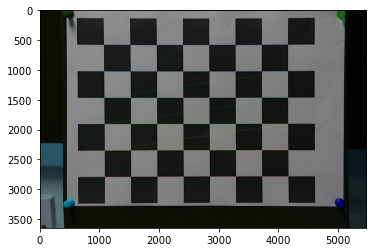

The Corners in the image 57 are 


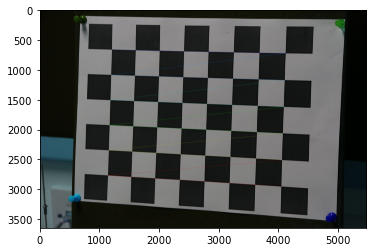

The Corners in the image 58 are 


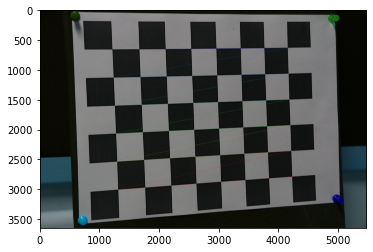

The Corners in the image 59 are 


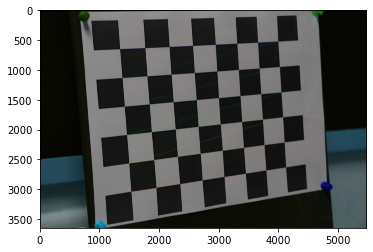

The Corners in the image 60 are 


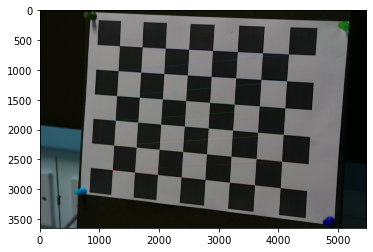

The Corners in the image 61 are 


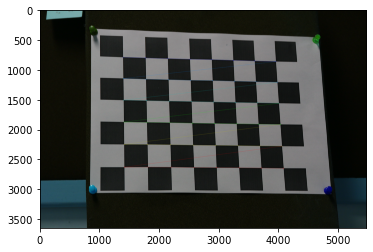

The Corners in the image 62 are 


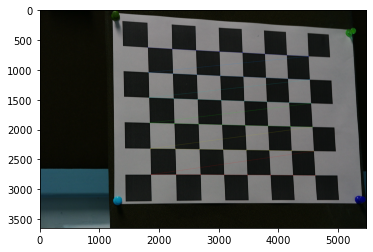

The Corners in the image 63 are 


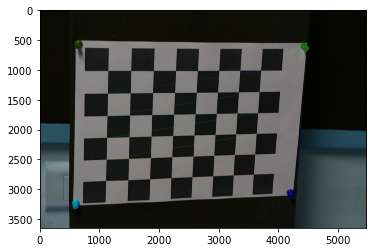

The Corners in the image 64 are 


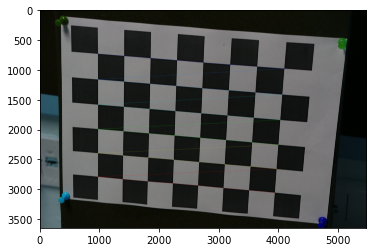

The Corners in the image 65 are 


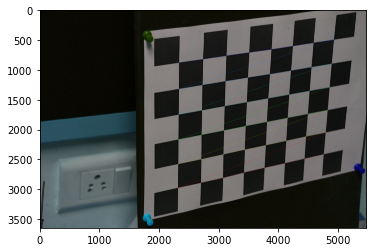

The Corners in the image 66 are 


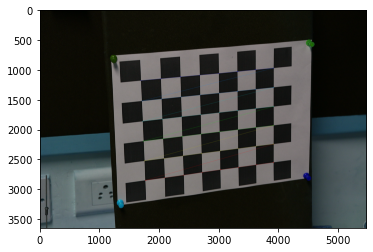

The Corners in the image 67 are 


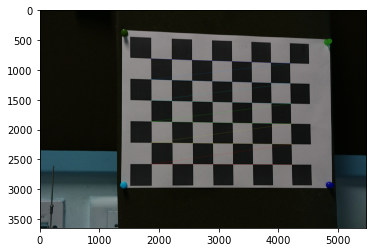

The Corners in the image 68 are 


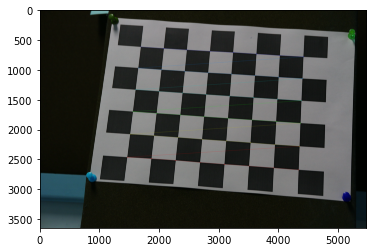

The Corners in the image 69 are 


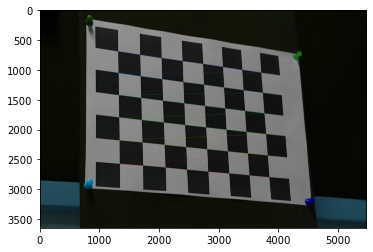

The Corners in the image 70 are 


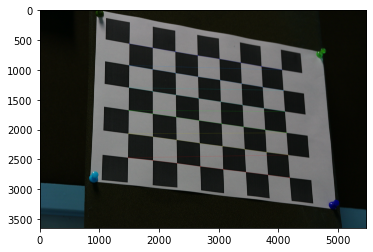

'K' matrix obtained using Zhang's Method is
[[1.36415094e+04 0.00000000e+00 3.31635881e+03]
 [0.00000000e+00 1.36632517e+04 1.50037396e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [14]:
#Code for zhangs here
import cv2


# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

#images import

images=[]
for i in range(56,71):
    
    fname ="./Images/Zhangs/IMG_54"+str(i)+".JPG"
    images.append(fname)

# preparing object points in the form of (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)

objp = np.zeros( (48,3) , np.float32)

objp[:,:2] = np.mgrid[0:8,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.

imgpoints = [] # 2d points in image plane.
objpoints = [] # 3d point in world space

for imgname in images:
    
    img = cv2.imread(imgname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Finding chess board corners
    
    ret, corners = cv2.findChessboardCorners(gray, (8,6),None)
    
    # If found, add object points, image points (after refining them)
    
    if ret == True:
        
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (8,6), corners2,ret)
        
        print("The Corners in the image " + imgname[-6] + imgname[-5] +" are ")
        
        plt.imshow(img)
        plt.show()

#Finding camera matrix K 
ret, K, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
print("'K' matrix obtained using Zhang's Method is")
print(K)

---
## 4.2
### Epipolar lines
#### Task 1

For this task, you have been given two images of the same scene taken from different view-points. The fundamental matrix that encodes their relative geometry as well as a subset of corresponding points have been provided to you. The images are in q2 folder.

Recall that given a point in one image, it's corresponding location in the other image can be found to along a line viz. the epipolar line. The task given to you is to draw the epipolar lines in the second image for each given point in the first image. You have to repeat this for the other image as well. Draw epipolar lines on the first image for the corresponding points in the second image.

The convention used for F is $x'^{T}Fx$ where $x'$ is the location of the point in the second image.

Image 1


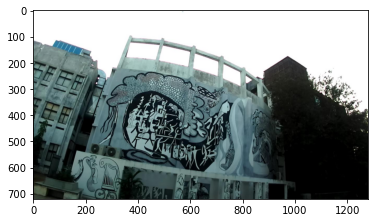

Image 2


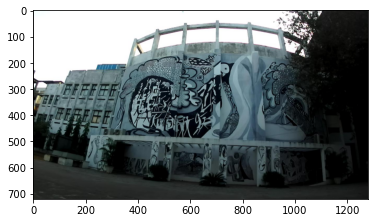

In [15]:
data_file = "q2/data.txt"

with open(data_file, 'r') as f:
    A = f.readlines()
    
img_points1 = A[2:12]
img_points1 = [i.strip()[:-1] for i in img_points1]
img_points1[0] = img_points1[0][1:]
img_points2 = A[15:25]
img_points2 = [i.strip()[:-1] for i in img_points2]
img_points2[0] = img_points2[0][1:]

F_mat = A[28:31]
F_mat = [i.strip()[:-1] for i in F_mat]
F_mat[0] = F_mat[0][1:]

img_1 = []
img_2 = []
F_MAT = []

for i in img_points1:
    img_1.append(np.fromstring(i[1:-1], sep=' '))
    
for i in img_points2:
    img_2.append(np.fromstring(i[1:-1], sep=' '))
    
for i in F_mat:
    F_MAT.append(np.fromstring(i[1:-1], sep=' '))

img_1 = np.array(img_1)
img_2 = np.array(img_2)
F_mat = np.array(F_MAT)

img1 = plt.imread("q2/img1.jpg")
img2 = plt.imread("q2/img2.jpg")

#Plotting the images fro refference
print("Image 1")
plt.imshow(img1)
plt.show()
print("Image 2")
plt.imshow(img2)
plt.show()



Provide a clear explanation on your approach for both this task and the next:

Firstly we match the dimentions for img_1, img_2 and F_mat.

From the coplanarity equation, we see that the equation of the epipolar line corresponding to points in image 1 is given by: **Fx=0** 

Exploiting the coplanarity constraint, we see that the equations of these lines would be given by: x<sup>T</sup>F = 0

We calculate 2 points from the line equations recieved and plot the lines using those 2 points.

Then we plot the points on the images.

### All required explanation is in the comments with the code

Image 1


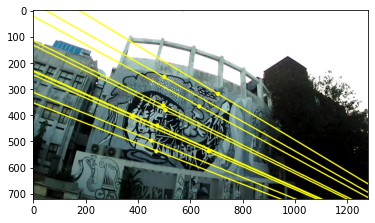

Image 2


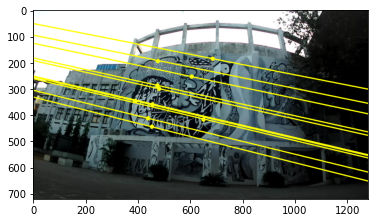

In [16]:
import cv2 as cv #Importing OpenCV

#Write code to plot epipolar lines on the images

#As dimensions are not matching (10,2) and (3,3), adding a ones vector as a column to both img_1 and img_2
ones = np.ones((10,1))
img_1_ones = np.append(img_1,ones,axis=1)
img_2_ones = np.append(img_2,ones,axis=1)

#Find epilines

#Using equations taught in class, we find the epipolar lines for both the images
#lines = F*Img_points.transpose and lines = Img_points*F 
epilines2 = np.dot(F_mat, img_1_ones.T) # as F_mat is (3,3) and img_1_ones is (10,3), we transpose img_1_ones
epilines1 = np.dot(img_2_ones, F_mat)

#Function to plot epilines
def drawlines(img,lines, pts):
    
    color=(255,255,0)
    r,c,_ = img.shape
    
    for r, pt1 in zip(lines, pts):  #Getting both lines[i] and points[i] together (Hence using zip)
        
        #We require 2 points to plot a line
        #Calculating both points here
        
        #1st point is the point where x = 0
        x0,y0 = map(int, [0 , -r[2] / r[1] ])
        
        #2nd point is the point where x = Last pixel of image (in this case it's 1280)
        x1,y1 = map(int, [c , -(r[2] + r[0] * c) / r[1] ])
        
        #Plotting the line using the points found
        img = cv.line(img, (x0,y0), (x1,y1), color ,4)
        
        #Plotting the given points using cv.circle
        img = cv.circle(img, tuple(pt1.astype(int)), 5, color, 5)
        
    return img


#Plotting the images with points and epilines
print("Image 1")
img1_ans = drawlines(img1, epilines1, img_1)
plt.imshow(img1_ans)
plt.show()
print("Image 2")
img2_ans = drawlines(img2, epilines2.T, img_2)
plt.imshow(img2_ans)
plt.show()

### Task 2
Report the location of the epipoles.

All the epipolar lines will converge at the epipole. If we want to try to find the coordinates of the epipole without using the epipolar lines, we can make a good estimate from the fundamental matrix itself. 

Equation of epipolar lines of first image is Fx=0. 
For epipole of first image, we do a SVD decomposition of F to get UDV<sup>T</sup>. 

2nd row of V<sup>T</sup> would correspond to the lowest eigenvalue which is a good approximation of the epipole. 

Equation of epipolar lines of second image is x<sup>T</sup>F=0. 

Taking whole transpose, we get F<sup>T</sup>x=0. So we do a SVD decomposition of F<sup>T</sup> to get UDV<sup>T</sup>. 

2nd row of V<sup>T</sup> would correspond to the lowest eigenvalue which is a good approximation of the epipole. 

In [17]:
#As we know, epipoles are found by doing SVD of the F matrix and taking the 2nd column of v

#For image 1, the epipoles are of the F matrix
U, D, V = np.linalg.svd(F_mat, full_matrices=False)
print("Epipoles of Image 1:", V[2,:])

#For image 1, the epipoles are of the transpose of the F matrix
U, D, V = np.linalg.svd(F_mat.T, full_matrices=False)
print("Epipoles of Image 2:", V[2,:])



Epipoles of Image 1: [8.75919893e-01 4.82456398e-01 4.05675052e-04]
Epipoles of Image 2: [-9.83333374e-01 -1.81811546e-01  1.91611592e-04]
